# Model Training - By Member - Target : Gout, Gastro, Migrane, Thyroid
# (Group 3)

Prepared by Tan Bee Hoon, modifed by LWL

16 Aug 2022  
22 Aug 2022 : Modified from Model11 "3HiGrp1"   


## Import Library

In [349]:
# Need to revert to version 1.20.0 of numpy for Numba required by Shap
#!pip install numpy==1.20.0 --user

In [350]:
import random 
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

import numpy as np 
from numpy import unique
from numpy import where

import pickle
from pandas import to_pickle
from pandas import read_pickle

import io
from datetime import date

from itertools import compress

# Libraries for Modelling
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.svm import NuSVC
from sklearn.svm import SVC
from sklearn import tree
from sklearn.inspection import permutation_importance
from sklearn import metrics 
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score

from imblearn.over_sampling import SMOTE 

import shap

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

## Global Setting

### Import File

In [351]:
TRAINING_FILE = "member_train_data_final.pkl"

### Include Outlier Removal

In [352]:
INCL_IFOREST = 0

### Include SMOTE

In [353]:
INCL_SMOTE = 0

In [354]:
# OVERSAMPLE_RATIO set here is to oversample the minority class with SMOTE 
# it corresponds to the desired ratio of
# number of samples in minority class over number of samples the majority class after resampling.
OVERSAMPLE_RATIO = 0.3

### Adjust Train Test Ratio

In [355]:
# enter value 0<x<1 
TEST_SIZE = 0.3

### Choose SelectFromModel Algo

In [356]:
# Choose either SVC or LR
SELECT_FR_MODEL_ALGO = "SVC"

### Choose to run Shap or not

In [357]:
# Choose either 1 or 0, 1 to run shap explainer for Random Forest
RUN_SHAP = 1

## Helper Function

In [358]:
def run_model_N_eval(X_train, X_test, y_train, y_test, model="RF"):
    if model == "RF":
        #model_def = RandomForestClassifier(max_depth=20, min_samples_split=20, random_state=42)
        model_def = RandomForestClassifier(max_depth=15, min_samples_split=20, min_samples_leaf=2, \
                                           max_features="sqrt", random_state=42, n_estimators=100)
    elif model == "LR":
        model_def = LogisticRegression(random_state=42)
        #model_def = LogisticRegression(random_state=42, solver="lbfgs", penalty="l2", C=1, class_weight="balanced")
    elif model == "SVM":
        model_def = svm.SVC(C=2.0, kernel='linear', probability=True, random_state=42)
    elif model == "NLSVM":
        model_def = svm.SVC(C=20.0, kernel='rbf', probability=True, random_state=42)
    elif model == "XGB":
        model_def = XGBClassifier(max_depth=3, n_estimators=100, 
                                  reg_alpha=10, reg_lambda=20, random_state=42)
    else:
        print("WRONG model type specified")
        return None
          
    # Pipeline
    if SELECT_FR_MODEL_ALGO == "SVC":
        clf = Pipeline([('feature_selection', SelectFromModel(LinearSVC(random_state=42),\
                        max_features=40)),
                        ('clf', model_def)])
    elif SELECT_FR_MODEL_ALGO == "LR":
        clf = Pipeline([('feature_selection', SelectFromModel(LogisticRegression(random_state=42), \
                        max_featrues=40)),
                        ('clf', model_def)])
    else:
        print("Please correct the decision for SELECT_FR_MODEL_ALGO, shd be either SVC or LR")
        
    # Fit Model
    clf.fit(X_train,y_train ) 

    # Prediction
    predicted_test = clf.predict(X_test)
    predicted_train = clf.predict(X_train)
    
    # Generate Confusion Matrix
    cf_train_matrix = metrics.confusion_matrix(y_train, predicted_train)
    cf_test_matrix = metrics.confusion_matrix(y_test, predicted_test)
    
    print("Model: ", model, "\n")
    print("Labels:", y_train.unique(), "\n")
    
    print("\n","#"*100)

    print("For Training Data:")
    print(cf_train_matrix, "\n")
    %matplotlib inline
    plt.figure(figsize=(10,8))
    sns.heatmap(cf_train_matrix, annot=True, fmt='d', vmin=0, vmax=y_train.shape[0]/len(y_train.unique()), cmap="Blues")
    plt.title("Training Data Confusion Matrix Heatmap")
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.show()
    
    print(metrics.classification_report(y_train, predicted_train, digits=4, target_names=target_names), "\n" )
    
    report_dict_train = classification_report(y_train, predicted_train, output_dict=True)
    report_df_train = pd.DataFrame(report_dict_train)
    
    print("\n","#"*100)

    print("For Testing Data:")
    print(cf_test_matrix, "\n")
    %matplotlib inline
    plt.figure(figsize=(10,8))
    sns.heatmap(cf_test_matrix, annot=True, fmt='d', vmin=0, vmax=y_test.shape[0]/len(y_train.unique()), cmap="Blues")
    plt.title("Testing Data Confusion Matrix Heatmap")
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.show()
    
    report_dict_test = classification_report(y_test, predicted_test, output_dict=True)
    report_df_test = pd.DataFrame(report_dict_test)
    
    print(metrics.classification_report(y_test, predicted_test,  digits=4, target_names=target_names), "\n" )

    print("\n","#"*100)
    
    return clf.named_steps['clf'], clf.named_steps['feature_selection'], report_df_train, report_df_test

In [359]:
def make_shap_waterfall_plot(shap_values, features, feature_names, num_display=20):
    column_list = feature_names
    feature_ratio = (np.abs(shap_values).sum(0) / np.abs(shap_values).sum()) * 100
    column_list = column_list[np.argsort(feature_ratio)[::-1]]
    feature_ratio_order = np.sort(feature_ratio)[::-1]
    cum_sum = np.cumsum(feature_ratio_order)
    column_list = column_list[:num_display]
    feature_ratio_order = feature_ratio_order[:num_display]
    cum_sum = cum_sum[:num_display]
    
    num_height = 0
    if (num_display >= 20) & (len(column_list) >= 20):
        num_height = (len(column_list) - 20) * 0.4
        
    fig, ax1 = plt.subplots(figsize=(8, 8 + num_height))
    ax1.plot(cum_sum[::-1], column_list[::-1], c='blue', marker='o')
    ax2 = ax1.twiny()
    ax2.barh(column_list[::-1], feature_ratio_order[::-1], alpha=0.6)
    
    ax1.grid(True)
    ax2.grid(False)
    ax1.set_xticks(np.arange(0, round(cum_sum.max(), -1)+1, 10))
    ax2.set_xticks(np.arange(0, round(feature_ratio_order.max(), -1)+1, 10))
    ax1.set_xlabel('Cumulative Ratio')
    ax2.set_xlabel('Composition Ratio')
    ax1.tick_params(axis="y", labelsize=13)
    plt.ylim(-1, len(column_list))

## Import Data

### Import Training Data

In [360]:
# Check exported data
df = read_pickle(TRAINING_FILE)

In [361]:
drop_max = [col for col in df if col.startswith('MAX_')]

In [362]:
drop_min = [col for col in df if col.startswith('MIN_')]

In [363]:
# drop redundant variables
drop_list = ['FirstBookDate','LastBookDate', "WaviedCount_NA", 
             'Mode_consult_waived_reason', "Mode_consult_hr", 
             'CountVisit_chronic_list',
                "ConsultHr_0",
                "ConsultHr_8", 
                "ConsultHr_9",
                "ConsultHr_10",                 
                "ConsultHr_11",
                "ConsultHr_12",
                "ConsultHr_13",
                "ConsultHr_14",
                "ConsultHr_15",
                "ConsultHr_16",
                "ConsultHr_17",
                "ConsultHr_18",
                "ConsultHr_19",
                "ConsultHr_20",
                "ConsultHr_21",
                "ConsultHr_22",
                "ConsultHr_23"]

In [364]:
final_drop = drop_max + drop_min + drop_list

In [365]:
df.drop(final_drop, inplace = True, axis = 1)

In [366]:
pd.set_option('display.max_rows', None)
df.head(3).transpose()

In [367]:
print("Shape of data: ", df.shape)

## Basic Training Data Investigation¶

In [368]:
print("Basic Data structure Info")
df.info("deep")

In [369]:
print("Basic Data Summary")
df.describe().transpose()

In [370]:
df.isnull().sum()

In [371]:
df.duplicated().sum()

In [372]:
all_list = df.columns.tolist()

In [373]:
#[TODO] TO INCLUDE CATEGORICAL INPUT TO CONSIDER
cat_list = ["gender"]  
df[cat_list] = df[cat_list].astype("category")

In [374]:
#[TODO] EDIT WHERE NEC
# LWL: this exc_list is derived from Model5 v1 - By Member - Target Others

exc_list = ['mem_id', 
            'Target_Chronic',
            #'Target_Dermatitis',
            'Target_Migraine',
            #'Target_Allergic',
            'Target_Gastro',
            #'Target_Hypertension',
            #'Target_Asthma',
            #'Target_Hyperlipidaemia',
            'Target_Thyroid',
            #'Target_Diabetes',
            'Target_Gout', 
            "CountVisit_Target_chronic",
            "AVE_count_chronic", 
            'CountVisit_symp_chronic_medicine_top-up',
            'CountVisit_symp_chronic_illness_management',
            "CountVisit_chronic_NoneChronic", 
            #"CountVisit_chronic_Atopic_dermatitis",
            "CountVisit_chronic_Migraine",
            #"CountVisit_chronic_Vasomotor_and_allergic_rhinitis",
            "CountVisit_chronic_Gastro-oesophageal_reflux_disease",
            #"CountVisit_chronic_Hypertension",
            #"CountVisit_chronic_Asthma",
            #"CountVisit_chronic_Hyperlipidaemia",
            "CountVisit_chronic_Thyroid",
            #"CountVisit_chronic_Diabetes",
            "CountVisit_chronic_Gout", 
            #"CountVisit_diag_J30",  #Vasomotor and allergic rhinitis
            "CountVisit_diag_K21",  #Gastro-esophageal reflux disease
            "CountVisit_diag_G43",  #Migraine
            #"CountVisit_diag_L20",  #Atopic dermatitis
            "CountVisit_diag_M10",  #Gout
            #"CountVisit_diag_I10",  #hypertension
            #"CountVisit_diag_J45",  #Asthma
            #"CountVisit_diag_E11",  #Diabetes
            #"CountVisit_diag_E78",  #hypercholesterolemia, hyperglyceridemia, Hyperlipidemia (high cholesterol), Hyperchylomicronemia 
            "CountVisit_diag_E03",  #Other hypothyroidism, i.e. Thyroid 
            "CountVisit_diag_E05",  #Thyrotoxicosis [hyperthyroidism], i.e. Thyroid
            "Target_3High",                                           
            "Target_Allergic_Dermatitis_Asthma",                                                   
            "Target_Migraine_Gastro_Thyroid_Gout",                     
            "CountVisit_symp_headache",           
            "CountVisit_symp_giddiness",             
            "CountVisit_symp_cold_sores", 
            "CountVisit_symp_rash",      
            "CountVisit_symp_sore_throat",  
            "CountVisit_symp_flu",          
            "CountVisit_symp_cough", 
            "CountVisit_symp_cold",    
            "CountVisit_symp_vomiting", 
            "CountVisit_symp_diarrhoea"
           ] 

In [375]:
select_col = [x for x in all_list if x not in exc_list] 

In [376]:
num_list = [x for x in select_col if x not in cat_list] 

In [377]:
num_list

## One Hot encoding

In [378]:
enc_df = pd.get_dummies(df[cat_list])

In [379]:
# Drop "gender_Unknown"
drop_oneHot = ["gender_Female", "gender_Male"]

In [380]:
#[TODO] TO EDIT AND DROP ONE CATEGORY LEVEL FOR ONE-HOT
enc_df = enc_df[drop_oneHot]

## Define input and output

In [381]:
# merge with numerical df for input
X = df[num_list].join(enc_df)   

In [382]:
X.shape

In [383]:
# Define the Target
y = df["Target_Migraine_Gastro_Thyroid_Gout"]  #[TODO] TO EDIT AND DEFINE TARGET LABEL 

In [384]:
# Check input variable names
feature_names = X.columns.tolist()

In [385]:
# EXPORT PICKLE
# export training Feature List for deployment
PKL_ALL_FEATURE_FILENAME = "model_Grp3_featurelist.pkl"
with open(PKL_ALL_FEATURE_FILENAME, "wb") as file:
    pickle.dump(feature_names, file)

## Train Test Split

In [386]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=42, stratify=y
)

In [387]:
y.value_counts()

In [388]:
y.value_counts(normalize=True)[1] * 100

## Oversample for Training

In [389]:
#[TODO] TO INCLUDE IF DATA TARGET CLASS TOO IMBALANCE

In [390]:
print(f'''Shape of X train without balancing: {X_train.shape}''')
print(f'''% Positive class of X train without balancing = {np.round(y_train.value_counts(normalize=True)[1] * 100, 2)}''')

Shape of X train without balancing: (3500, 139)
% Positive class of X train without balancing = 7.51


In [391]:
# OVERSAMPLE_RATIO set here is to oversample the minority class with SMOTE 
# it corresponds to the desired ratio of
# number of samples in minority class over number of samples the majority class after resampling.
if INCL_SMOTE == 1:
    sm = SMOTE(random_state=42, sampling_strategy=OVERSAMPLE_RATIO)
    X_train, y_train = sm.fit_resample(X_train, y_train)
    print(f'''Shape of X train after SMOTE: {X_train.shape}''')
    print(f'''% Positive class of X train after SMOTE = {np.round(y_train.value_counts(normalize=True)[1] * 100, 2)}''')
else: 
    print("SMOTE not included.")

SMOTE not included.


In [392]:
print("SMOTE over-sampling is not done for Test data")
print(f'''Shape of X Test after SMOTE: {X_test.shape}''')
print(f'''% Positive class f X Test before SMOTE = {np.round(y_test.value_counts(normalize=True)[1] * 100, 2)}''')

SMOTE over-sampling is not done for Test data
Shape of X Test after SMOTE: (1500, 139)
% Positive class f X Test before SMOTE = 7.53


Note: Not over-sampling for Test data to maintain data integrity

## Remove Outliers

Isolation Forest, or iForest for short, is a tree-based anomaly detection algorithm.

It is based on modeling the normal data in such a way as to isolate anomalies that are both few in number and different in the feature space.

The method is based on two anomalies’ quantitative properties:

i) they are the minority consisting of fewer instances and 

ii) they have attribute-values that are very different from those of normal instances.
The scikit-learn library provides an implementation of Isolation Forest in the IsolationForest class.

In [393]:
# identify outliers in the training dataset

if INCL_IFOREST ==1: 
    iso = IsolationForest(contamination=0.1,random_state= 0)
    yhat = iso.fit_predict(X_train)

    # select all rows that are not outliers
    mask = yhat != -1
    X_train, y_train = X_train[mask], y_train[mask]

    print("No of outliers marked: ")
    sum(yhat == -1)
    
    # summarize the shape of the updated training dataset
    print("Shape of processed dataset, X_train vs y_train after removing outliers")
    print(X_train.shape, y_train.shape)

## Standardized Data

In [394]:
sc =  StandardScaler()
# Fit and Transform the training dataset
print("Fit and Transform the training dataset")
X_train = sc.fit_transform(X_train)

Fit and Transform the training dataset


In [395]:
X_train

array([[-0.59890791, -0.73958131,  2.34860317, ...,  0.04450981,
         0.81795539, -0.74489228],
       [ 0.56985579,  0.03012865, -0.35805178, ..., -0.40760341,
         0.81795539, -0.74489228],
       [-0.59890791, -0.73958131, -0.35805178, ...,  0.04450981,
         0.81795539, -0.74489228],
       ...,
       [-0.59890791, -0.73958131,  2.34860317, ...,  0.04450981,
         0.81795539, -0.74489228],
       [-0.59890791,  3.10896848, -0.35805178, ...,  0.21472286,
         0.81795539, -0.74489228],
       [-0.59890791, -0.73958131, -0.35805178, ...,  0.04450981,
         0.81795539, -0.74489228]])

In [396]:
# Transform the testing dataset
print("Transform the testing dataset (no fitting)")
X_test = sc.transform (X_test)

Transform the testing dataset (no fitting)


In [397]:
# EXPORT PICKLE
PKL_STANDARDSCALER_FILENAME = "model_Grp3_standardard_scaler.pkl"
with open(PKL_STANDARDSCALER_FILENAME, "wb") as file:
    pickle.dump(sc, file)

## Model Selection

In [398]:
target_names = ['Non-MigraineGastroThyroidGout', 'MigraineGastroThyroidGout']   #Define Target Names

### Logistic Model

Model:  LR 

Labels: [0 1] 


 ####################################################################################################
For Training Data:
[[3206   31]
 [ 209   54]] 



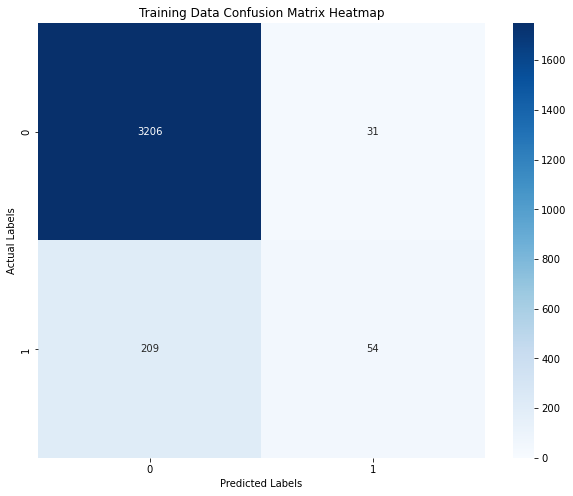

                               precision    recall  f1-score   support

Non-MigraineGastroThyroidGout     0.9388    0.9904    0.9639      3237
    MigraineGastroThyroidGout     0.6353    0.2053    0.3103       263

                     accuracy                         0.9314      3500
                    macro avg     0.7870    0.5979    0.6371      3500
                 weighted avg     0.9160    0.9314    0.9148      3500
 


 ####################################################################################################
For Testing Data:
[[1368   19]
 [  89   24]] 



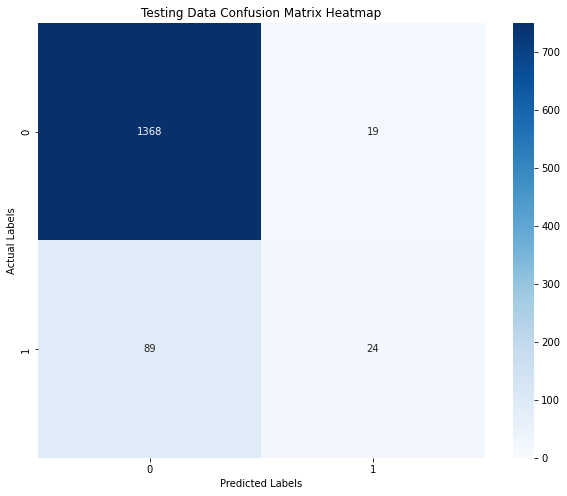

                               precision    recall  f1-score   support

Non-MigraineGastroThyroidGout     0.9389    0.9863    0.9620      1387
    MigraineGastroThyroidGout     0.5581    0.2124    0.3077       113

                     accuracy                         0.9280      1500
                    macro avg     0.7485    0.5993    0.6349      1500
                 weighted avg     0.9102    0.9280    0.9127      1500
 


 ####################################################################################################


In [399]:
LR_model, LR_selectFeature, LR_report_train,  LR_report_test = \
    run_model_N_eval(X_train, X_test, y_train, y_test, model="LR")

In [400]:
# LR Target Report 
LR_frame = { 'Train': LR_report_train["1"], 'Test': LR_report_test["1"] }
LR_report_output= pd.DataFrame(LR_frame)
LR_report_output

,Train,Test
precision,0.635294,0.558140
recall,0.205323,0.212389
f1-score,0.310345,0.307692
support,263.000000,113.000000


In [401]:
# EXPORT PICKLE
# export result
PKL_LR_RESULT_FILENAME = "model_Grp3_result_logistic.pkl"
with open(PKL_LR_RESULT_FILENAME, "wb") as file:
    pickle.dump(LR_report_output, file)

### Support Vector Machine (Linear)

Model:  SVM 

Labels: [0 1] 


 ####################################################################################################
For Training Data:
[[3237    0]
 [ 263    0]] 



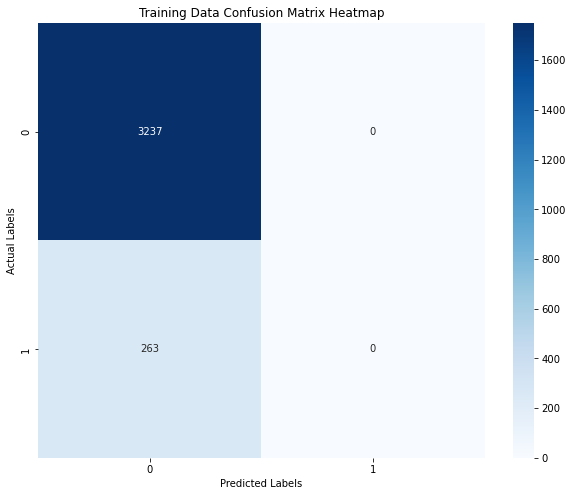

                               precision    recall  f1-score   support

Non-MigraineGastroThyroidGout     0.9249    1.0000    0.9610      3237
    MigraineGastroThyroidGout     0.0000    0.0000    0.0000       263

                     accuracy                         0.9249      3500
                    macro avg     0.4624    0.5000    0.4805      3500
                 weighted avg     0.8554    0.9249    0.8888      3500
 


 ####################################################################################################
For Testing Data:
[[1387    0]
 [ 113    0]] 



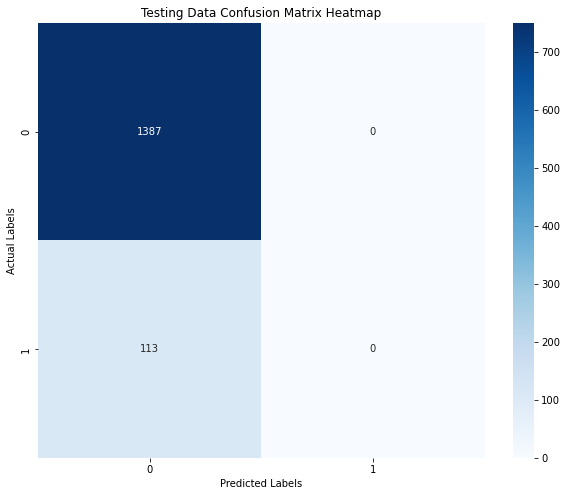

                               precision    recall  f1-score   support

Non-MigraineGastroThyroidGout     0.9247    1.0000    0.9609      1387
    MigraineGastroThyroidGout     0.0000    0.0000    0.0000       113

                     accuracy                         0.9247      1500
                    macro avg     0.4623    0.5000    0.4804      1500
                 weighted avg     0.8550    0.9247    0.8885      1500
 


 ####################################################################################################


In [402]:
SVM_model, SVM_selectFeature, SVM_report_train, SVM_report_test = \
    run_model_N_eval(X_train, X_test, y_train, y_test, "SVM")

In [403]:
# SVM Target Report 
SVM_frame = { 'Train': SVM_report_train["1"], 'Test': SVM_report_test["1"] }
SVM_report_output= pd.DataFrame(SVM_frame)
SVM_report_output

,Train,Test
precision,0.0,0.0
recall,0.0,0.0
f1-score,0.0,0.0
support,263.0,113.0


In [404]:
# EXPORT PICKLE
# export result
PKL_SVM_RESULT_FILENAME = "model_Grp3_result_svm.pkl"
with open(PKL_SVM_RESULT_FILENAME, "wb") as file:
    pickle.dump(SVM_report_output, file)

### Support Vector Machine (Non-Linear)

Model:  NLSVM 

Labels: [0 1] 


 ####################################################################################################
For Training Data:
[[3236    1]
 [ 105  158]] 



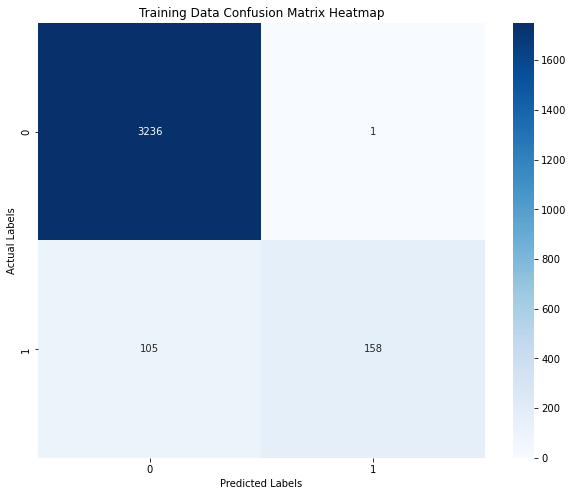

                               precision    recall  f1-score   support

Non-MigraineGastroThyroidGout     0.9686    0.9997    0.9839      3237
    MigraineGastroThyroidGout     0.9937    0.6008    0.7488       263

                     accuracy                         0.9697      3500
                    macro avg     0.9811    0.8002    0.8664      3500
                 weighted avg     0.9705    0.9697    0.9662      3500
 


 ####################################################################################################
For Testing Data:
[[1354   33]
 [  97   16]] 



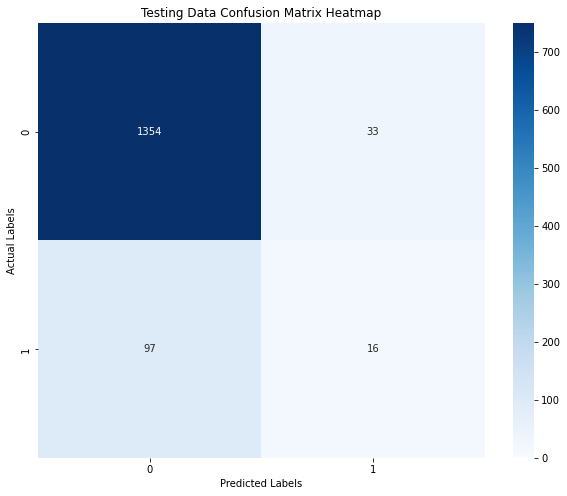

                               precision    recall  f1-score   support

Non-MigraineGastroThyroidGout     0.9331    0.9762    0.9542      1387
    MigraineGastroThyroidGout     0.3265    0.1416    0.1975       113

                     accuracy                         0.9133      1500
                    macro avg     0.6298    0.5589    0.5759      1500
                 weighted avg     0.8875    0.9133    0.8972      1500
 


 ####################################################################################################


In [405]:
NLSVM_model, NLSVM_selectFeature, NLSVM_report_train, NLSVM_report_test = \
    run_model_N_eval(X_train, X_test, y_train, y_test, "NLSVM")

In [406]:
# NLSVM Target Report 
NLSVM_frame = { 'Train': NLSVM_report_train["1"], 'Test': NLSVM_report_test["1"] }
NLSVM_report_output= pd.DataFrame(NLSVM_frame)
NLSVM_report_output

,Train,Test
precision,0.993711,0.326531
recall,0.600760,0.141593
f1-score,0.748815,0.197531
support,263.000000,113.000000


In [407]:
# EXPORT PICKLE
# export result
PKL_NLSVM_RESULT_FILENAME = "model_Grp3_result_nonlinearsvm.pkl"
with open(PKL_NLSVM_RESULT_FILENAME, "wb") as file:
    pickle.dump(NLSVM_report_output, file)

### Random Forest

Model:  RF 

Labels: [0 1] 


 ####################################################################################################
For Training Data:
[[3237    0]
 [ 237   26]] 



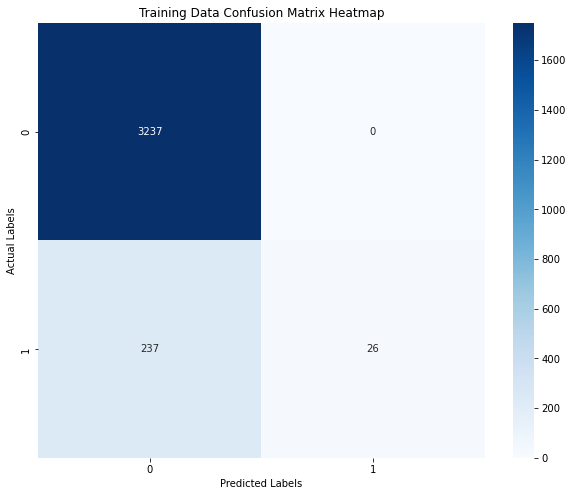

                               precision    recall  f1-score   support

Non-MigraineGastroThyroidGout     0.9318    1.0000    0.9647      3237
    MigraineGastroThyroidGout     1.0000    0.0989    0.1799       263

                     accuracy                         0.9323      3500
                    macro avg     0.9659    0.5494    0.5723      3500
                 weighted avg     0.9369    0.9323    0.9057      3500
 


 ####################################################################################################
For Testing Data:
[[1385    2]
 [ 110    3]] 



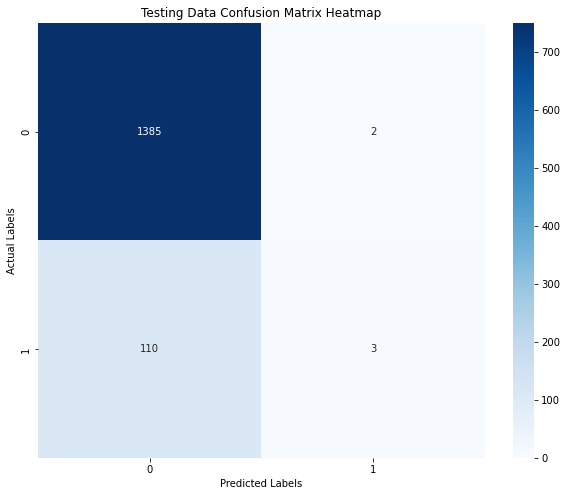

                               precision    recall  f1-score   support

Non-MigraineGastroThyroidGout     0.9264    0.9986    0.9611      1387
    MigraineGastroThyroidGout     0.6000    0.0265    0.0508       113

                     accuracy                         0.9253      1500
                    macro avg     0.7632    0.5126    0.5060      1500
                 weighted avg     0.9018    0.9253    0.8926      1500
 


 ####################################################################################################


In [408]:
RF_model, RF_selectFeature, RF_report_train, RF_report_test  = \
    run_model_N_eval(X_train, X_test, y_train, y_test, "RF")

In [409]:
# RF Target Report 
RF_frame = { 'Train': RF_report_train["1"], 'Test': RF_report_test["1"] }
RF_report_output= pd.DataFrame(RF_frame)
RF_report_output

,Train,Test
precision,1.000000,0.600000
recall,0.098859,0.026549
f1-score,0.179931,0.050847
support,263.000000,113.000000


In [410]:
# EXPORT PICKLE
# export result
PKL_RF_RESULT_FILENAME = "model_Grp3_result_randomforest.pkl"
with open(PKL_RF_RESULT_FILENAME, "wb") as file:
    pickle.dump(RF_report_output, file)

### XGBoost

[20:22:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model:  XGB 

Labels: [0 1] 


 ####################################################################################################
For Training Data:
[[3232    5]
 [ 247   16]] 



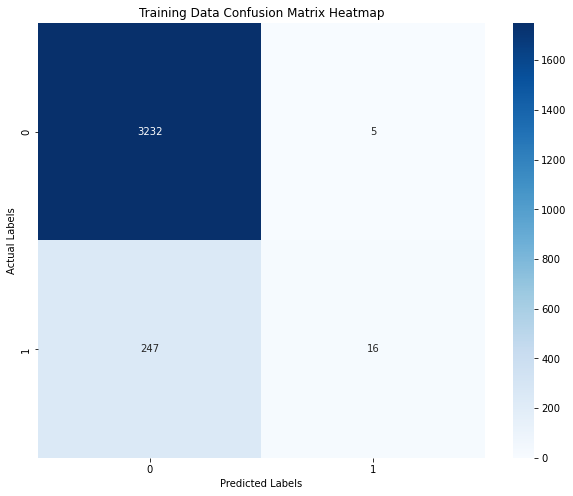

                               precision    recall  f1-score   support

Non-MigraineGastroThyroidGout     0.9290    0.9985    0.9625      3237
    MigraineGastroThyroidGout     0.7619    0.0608    0.1127       263

                     accuracy                         0.9280      3500
                    macro avg     0.8455    0.5296    0.5376      3500
                 weighted avg     0.9164    0.9280    0.8986      3500
 


 ####################################################################################################
For Testing Data:
[[1385    2]
 [ 109    4]] 



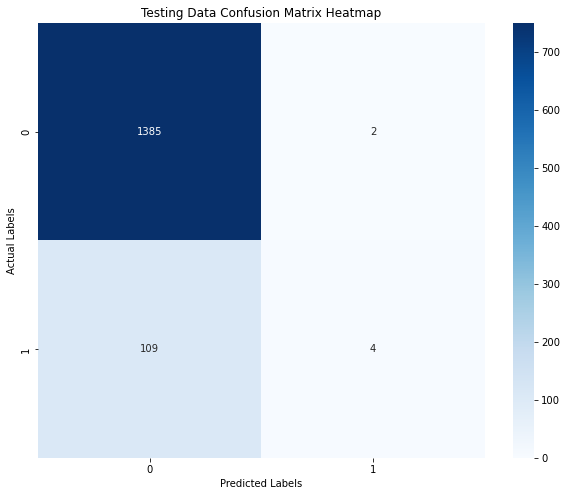

                               precision    recall  f1-score   support

Non-MigraineGastroThyroidGout     0.9270    0.9986    0.9615      1387
    MigraineGastroThyroidGout     0.6667    0.0354    0.0672       113

                     accuracy                         0.9260      1500
                    macro avg     0.7969    0.5170    0.5143      1500
                 weighted avg     0.9074    0.9260    0.8941      1500
 


 ####################################################################################################


In [411]:
XGB_model, XGB_selectFeature,  XGB_report_train, XGB_report_test = \
    run_model_N_eval(X_train, X_test, y_train, y_test, "XGB")

In [412]:
# XGB Target Report 
XGB_frame = { 'Train': XGB_report_train["1"], 'Test': XGB_report_test["1"] }
XGB_report_output= pd.DataFrame(XGB_frame)
XGB_report_output

,Train,Test
precision,0.761905,0.666667
recall,0.060837,0.035398
f1-score,0.112676,0.067227
support,263.000000,113.000000


In [413]:
# EXPORT PICKLE
# export result
PKL_XGB_RESULT_FILENAME = "model_Grp3_result_xgb.pkl"
with open(PKL_XGB_RESULT_FILENAME, "wb") as file:
    pickle.dump(XGB_report_output, file)

## Feature Selected

In [414]:
# EXPORT PICKLE
PKL_SELECT_MODEL_FILENAME = "model_Grp3_selectfeature.pkl"
with open(PKL_SELECT_MODEL_FILENAME, "wb") as file:
    pickle.dump(LR_selectFeature, file)

In [415]:
X_newTest_LR = LR_selectFeature.transform(X_test)
X_newTrain_LR = LR_selectFeature.transform(X_train)
feature_idx_LR = LR_selectFeature.get_support()
final_selectList_LR = list(compress(feature_names, feature_idx_LR))
len(final_selectList_LR)

40

In [416]:
final_selectList_LR

['Mem_CountBooking',
 'AVE_count_diagnosis',
 'AVE_count_medication',
 'CountVisit_is_mc_issued',
 'CountVisit_diag_T88',
 'CountVisit_diag_R51',
 'CountVisit_diag_N94',
 'CountVisit_diag_G44',
 'CountVisit_diag_M79',
 'CountVisit_diag_J02',
 'CountVisit_diag_J06',
 'CountVisit_diag_R21',
 'CountVisit_diag_M62',
 'CountVisit_diag_A09',
 'CountVisit_diag_U07',
 'CountVisit_diag_K29',
 'CountVisit_diag_H81',
 'CountVisit_diag_N39',
 'CountVisit_diag_R42',
 'CountVisit_diag_R50',
 'CountVisit_diag_M54',
 'CountVisit_diag_L03',
 'CountVisit_diag_K58',
 'CountVisit_diag_Z71',
 'CountVisit_diag_E11',
 'CountVisit_diag_Y42',
 'CountVisit_diag_R10',
 'CountVisit_diag_J03',
 'CountVisit_diag_P39',
 'CountVisit_diag_N64',
 'CountVisit_chronic_Diabetes',
 'DiffDays_Vist',
 'ConsultHr_8to10',
 'ConsultHr_11to13',
 'ConsultHr_14to17',
 'ConsultHr_18to21',
 'ConsultHr_22to23',
 'Prin1_sym_common',
 'Prin3_sym_headache',
 'Prin4_sym_diarrhea']

In [417]:
X_newTest_SVM = SVM_selectFeature.transform(X_test)
X_newTrain_SVM = SVM_selectFeature.transform(X_train)
feature_idx_SVM = SVM_selectFeature.get_support()
final_selectList_SVM = list(compress(feature_names, feature_idx_SVM))
len(final_selectList_SVM)

40

In [418]:
X_newTest_NLSVM = NLSVM_selectFeature.transform(X_test)
X_newTrain_NLSVM = NLSVM_selectFeature.transform(X_train)
feature_idx_NLSVM = NLSVM_selectFeature.get_support()
final_selectList_NLSVM = list(compress(feature_names, feature_idx_NLSVM))
len(final_selectList_NLSVM)

40

In [419]:
X_newTest_RF = RF_selectFeature.transform(X_test)
X_newTrain_RF = RF_selectFeature.transform(X_train)
feature_idx_RF = RF_selectFeature.get_support()
final_selectList_RF = list(compress(feature_names, feature_idx_RF))
len(final_selectList_RF)

40

In [420]:
X_newTest_XGB = XGB_selectFeature.transform(X_test)
X_newTrain_XGB = XGB_selectFeature.transform(X_train)
feature_idx_XGB = XGB_selectFeature.get_support()
final_selectList_XGB = list(compress(feature_names, feature_idx_XGB))
len(final_selectList_XGB)

40

## ROC

In [421]:
# EXPORT PICKLE
#Export LR_model for deployment
PKL_LR_MODEL_FILENAME = "model_Grp3_logistic.pkl"
with open(PKL_LR_MODEL_FILENAME, "wb") as file:
    pickle.dump(LR_model, file)

In [422]:
# EXPORT PICKLE
#Export SVM_model for deployment
PKL_SVM_MODEL_FILENAME = "model_Grp3_svm.pkl"
with open(PKL_SVM_MODEL_FILENAME, "wb") as file:
    pickle.dump(SVM_model, file)

In [423]:
# EXPORT PICKLE
#Export Non-linear SVM_model for deployment
PKL_NLSVM_MODEL_FILENAME = "model_Grp3_nonlinear_svm.pkl"
with open(PKL_NLSVM_MODEL_FILENAME, "wb") as file:
    pickle.dump(NLSVM_model, file)

In [424]:
# EXPORT PICKLE
#Export RF_model for deployment
PKL_RF_MODEL_FILENAME = "model_Grp3_randomforest.pkl"
with open(PKL_RF_MODEL_FILENAME, "wb") as file:
    pickle.dump(RF_model, file)

In [425]:
# EXPORT PICKLE
#Export XGB_model for deployment
PKL_XGB_MODEL_FILENAME = "model_Grp3_xgb.pkl"
with open(PKL_XGB_MODEL_FILENAME, "wb") as file:
    pickle.dump(XGB_model, file)

In [426]:
lr_probs = LR_model.predict_proba(X_newTest_LR)[:,1]
lr_auc = roc_auc_score(y_test, lr_probs, average=None)
lr_auc = round(lr_auc,5)
lr_auc

0.86744

In [427]:
svm_probs = SVM_model.predict_proba(X_newTest_SVM)[:,1]
svm_auc = roc_auc_score(y_test, svm_probs, average=None)
svm_auc = round(svm_auc,5)
svm_auc

0.83365

In [428]:
nlsvm_probs = NLSVM_model.predict_proba(X_newTest_NLSVM)[:,1]
nlsvm_auc = roc_auc_score(y_test, nlsvm_probs, average=None)
nlsvm_auc = round(nlsvm_auc, 5)
nlsvm_auc

0.7893

In [429]:
rf_probs = RF_model.predict_proba(X_newTest_RF)[:,1]
rf_auc = roc_auc_score(y_test, rf_probs, average=None)
rf_auc = round(rf_auc, 5)
rf_auc

0.79581

In [430]:
xgb_probs = XGB_model.predict_proba(X_newTest_XGB)[:,1]
xgb_auc = roc_auc_score(y_test, xgb_probs, average=None)
xgb_auc = round(xgb_auc, 5)
xgb_auc

0.79753

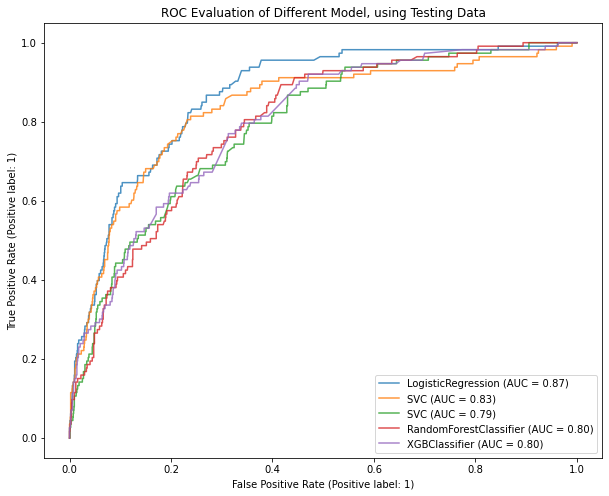

In [431]:
%matplotlib inline
plt.figure(figsize=(10,8))
ax = plt.gca()
LR_disp = RocCurveDisplay.from_estimator(LR_model, X_newTest_LR, y_test, ax=ax, alpha=0.8)
SVM_disp = RocCurveDisplay.from_estimator(SVM_model, X_newTest_SVM, y_test, ax=ax, alpha=0.8)
NLSVM_disp = RocCurveDisplay.from_estimator(NLSVM_model, X_newTest_NLSVM, y_test, ax=ax, alpha=0.8)
RF_disp = RocCurveDisplay.from_estimator(RF_model, X_newTest_RF, y_test, ax=ax, alpha=0.8)
XGB_disp = RocCurveDisplay.from_estimator(XGB_model, X_newTest_XGB, y_test, ax=ax, alpha=0.8)
plt.title("ROC Evaluation of Different Model, using Testing Data")
plt.show()

## Model Explanability

### Random Forest 

EXPLAIN THE EFFECT OF FEATURES ON TARGET CLASS USING SHAP VALUES


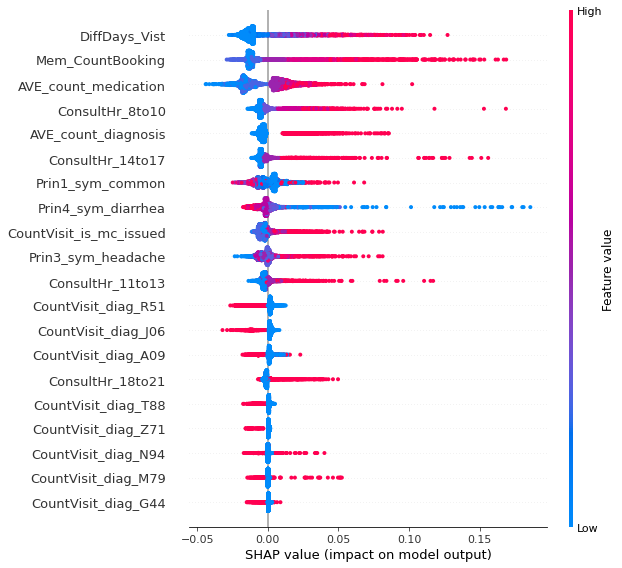

In [432]:
if RUN_SHAP == 1:
    # [TODO] To choose the final model and correct selected features selected
    MODEL_SELECTED = RF_model
    X_TRAIN = X_newTrain_RF
    X_TEST = X_newTest_RF
    FINAL_LIST = final_selectList_RF
    
    explainer = shap.TreeExplainer(MODEL_SELECTED)
    
    shap_values = explainer.shap_values(X_TRAIN)
    
    #Summarize the effect of all the features on Target
    # To make the interpretation easier
    print("EXPLAIN THE EFFECT OF FEATURES ON TARGET CLASS USING SHAP VALUES")
    shap.summary_plot(shap_values[1], X_TRAIN, feature_names=FINAL_LIST)

@end